In [87]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

#85 percent train 15 percent test

In [88]:
df = pd.read_csv('variable_selected_county_dataset.csv', index_col=0)

In [4]:
df.entity.unique()

array(['California-Los Angeles', 'California-Orange',
       'California-San Diego', 'Florida-Miami-Dade', 'Illinois-Cook',
       'Nevada-Clark', 'New York-Nassau', 'New York-New York City',
       'New York-Suffolk', 'Pennsylvania-Philadelphia', 'Texas-Harris',
       'Texas-Tarrant'], dtype=object)

In [133]:
nyc

,date,incremental_cases
1620,2020-03-10,2
1621,2020-03-11,9
1622,2020-03-12,13
1623,2020-03-13,10
1624,2020-03-14,28
...,...,...
1885,2020-11-30,520
1886,2020-12-01,461
1887,2020-12-02,826
1888,2020-12-03,757


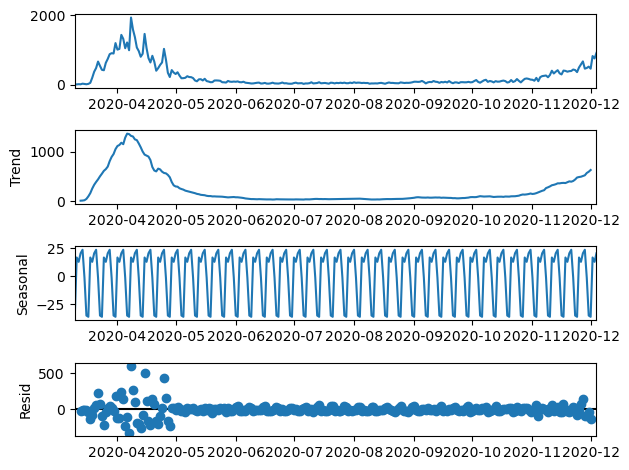

In [122]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller

data = pd.read_csv('variable_selected_county_dataset.csv').iloc[:, 1:]


def difference(df):
    df['incremental_cases'] = df['incremental_cases'].diff().fillna(df['incremental_cases'])
    return df


nyc = data[data['entity'] == 'New York-Nassau'].loc[:, ['date', 'incremental_cases']]
nyc['incremental_cases'] = nyc['incremental_cases'].astype('int')
nyc['date'] = pd.to_datetime(nyc['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = nyc.iloc[:230, :]
test = nyc.iloc[230:, :]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# NYC data is stationary without any differencing
stationary_test(train.incremental_cases)

(-3.5631021476017817, 0.006506904294634441)

In [117]:
arimaModel = miami[['date', 'incremental_cases']]
train = arimaModel.head(int(0.85*len(arimaModel))+1)
test = arimaModel.tail(int(0.15*len(arimaModel)))

In [128]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [1, 3,5,7]
d_values = [2, 1, 0]
q_values = [12, 7, 10]

best_score, best_cfg = float("inf"), None

for train_index, val_index in tscv.split(train):
    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                model = ARIMA(train_data.incremental_cases, order = order).fit()
                forecast = model.forecast(steps=val_data.shape[0])
                mse = mean_squared_error(val_data.incremental_cases, forecast)
                if mse < best_score:
                    best_score, best_cfg = mse, order

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

Best ARIMA parameters: (3, 1, 7) with MSE: 102.89963318012266


-1.2992635475978327


<AxesSubplot:xlabel='date'>

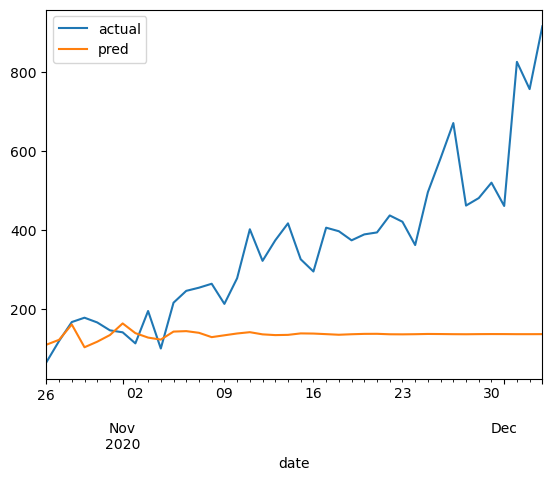

In [130]:
model = ARIMA(train.incremental_cases, order=(3, 1, 7)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])